In [2]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess

from data import get_periodic_process
from utils import get_figure, time_plot, acovf_plot, plot_fft, arma_theoretical_spectral_density
from ex_data import get_sea_surface_temp

### Exercise 9
Simulate different synthetic periodic/aperiodic signals.<br>
• Review time-plot, ACF and auto-covariance plots.<br>
• Compute periodogram and review spectra.<br>
• Repeat exercise with noisy synthetic signals.<br>

Analyze the spectral density of known processes.<br>
• Review how parameters affect the spectral density.<br>
• Integrate the spectral density to confirm it matches the total variance.<br>
• Generate signals and compare periodogram with spectral density.<br>

Study real-world time series.<br>
• Compute periodogram and review spectra.<br>

## Periodic process

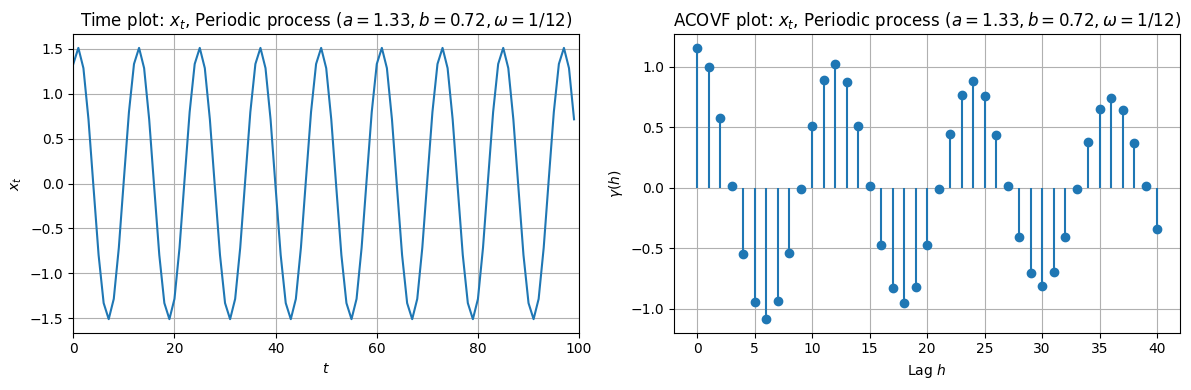

In [3]:
n = 100
x_t, x_name = get_periodic_process(seed=10, npoints=n, sd=1, period=12)
fig, (ax1, ax2) = get_figure(ncols=2)
time_plot(
    np.arange(n),
    x_t,
    title=f"$x_t$, {x_name}",
    prefix_title=True,
    ax=ax1,
    xlim=(0, 100),
)
acovf_plot(
    x_t,
    40,
    title=f"$x_t$, {x_name}",
    ax=ax2,
)
fig.tight_layout()

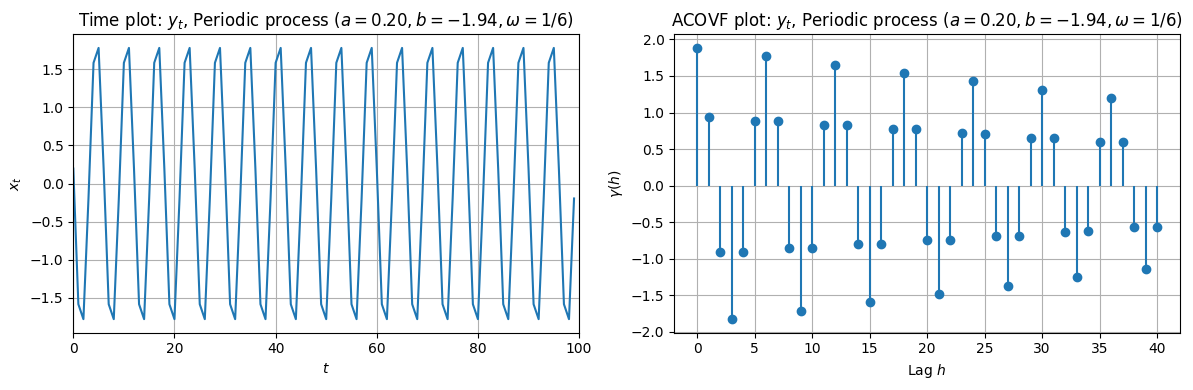

In [4]:
y_t, y_name = get_periodic_process(seed=26, npoints=n, sd=1, period=6)
fig, (ax1, ax2) = get_figure(ncols=2)
time_plot(
    np.arange(n),
    y_t,
    title=f"$y_t$, {y_name}",
    prefix_title=True,
    ax=ax1,
    xlim=(0, 100),
)
acovf_plot(
    y_t,
    40,
    title=f"$y_t$, {y_name}",
    ax=ax2,
)
fig.tight_layout()

### Mixtures of periodic series

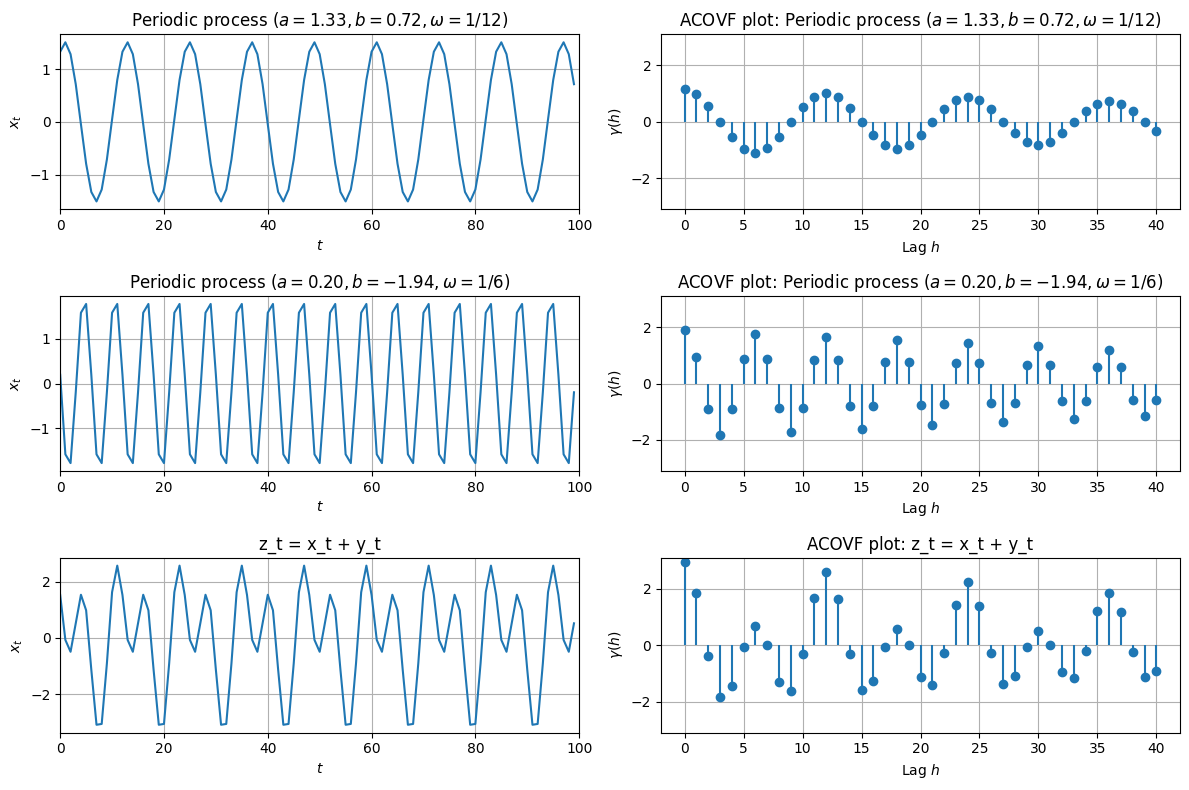

In [5]:
z_t = x_t + y_t
fig, axs = get_figure(3, 2, figsize=(12, 8))
for i, (x, name) in enumerate([(x_t, x_name), (y_t, y_name), (z_t, "z_t = x_t + y_t")]):
    time_plot(
        np.arange(n),
        x,
        title=f"{name}",
        ax=axs[i*2],
        xlim=(0, 100),
    )
    acovf_plot(
        x,
        40,
        title=f"{name}",
        ax=axs[i*2+1],
    )
    axs[i*2+1].set_ylim(-3.1, 3.1)
fig.tight_layout()

## Periodogram

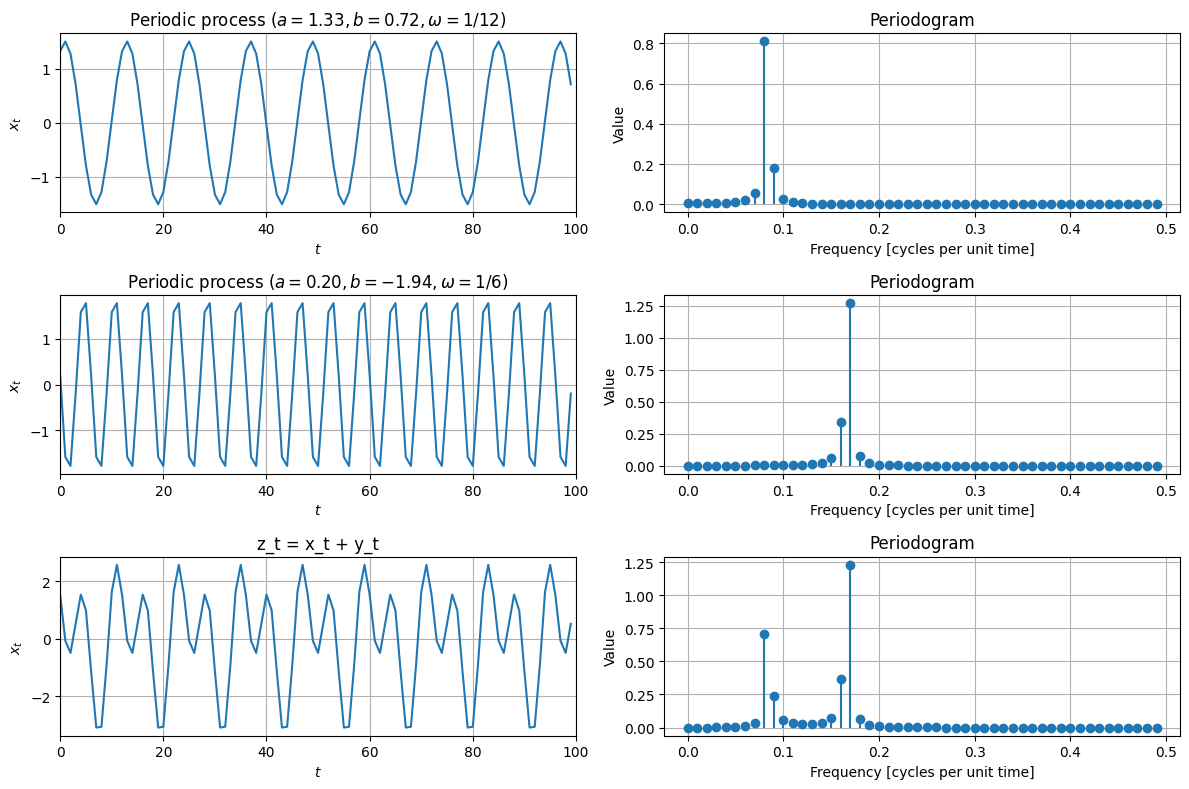

In [6]:
fig, axs = get_figure(3, 2, figsize=(12, 8))
for i, (x, name) in enumerate([(x_t, x_name), (y_t, y_name), (z_t, "z_t = x_t + y_t")]):
    time_plot(
        np.arange(n),
        x,
        title=f"{name}",
        ax=axs[i*2],
        xlim=(0, 100),
    )
    plot_fft(
        axs[i*2+1],
        x,
        periodogram=True,
    )
fig.tight_layout()

## Spectral density

### Moving average process

<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_37007/2621238395.py:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  title="Spectral Density of MA(1) Process with $W_t\sim \mathcal{N}(0, 1)$",


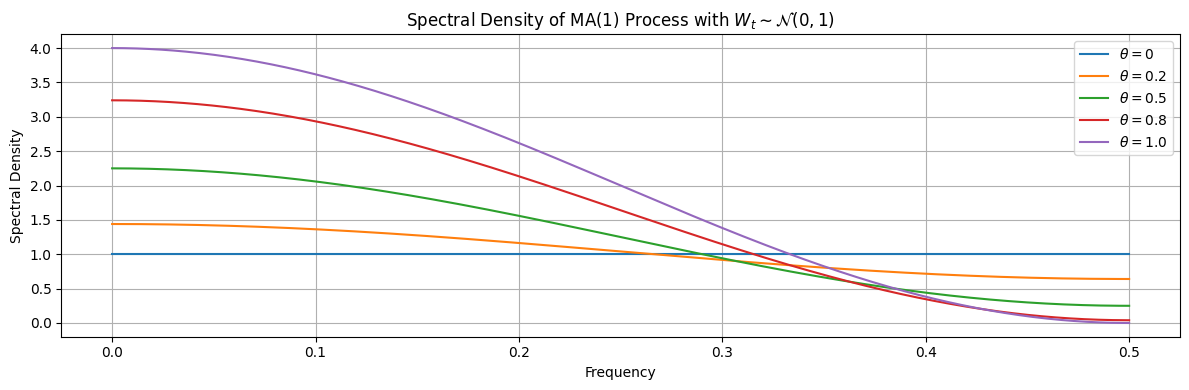

In [7]:
sigma = 1
theta_values = [0, 0.2, 0.5, 0.8, 1.0]
frequencies = np.linspace(0, 0.5, 500)

fig, [ax] = get_figure()
for theta in theta_values:
    spectral_density = sigma**2 * (1 + theta**2 + 2 * theta * np.cos(2 * np.pi * frequencies))
    time_plot(
        frequencies,
        spectral_density,
        title="Spectral Density of MA(1) Process with $W_t\sim \mathcal{N}(0, 1)$",
        xlabel="Frequency",
        ylabel="Spectral Density",
        label=f"$\\theta = {theta}$",
        ax=ax,
    )
ax.legend()
fig.tight_layout()

### Autoregressive process

<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_37007/3394655760.py:11: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  title="Spectral Density of AR(1) Process with $W_t\sim \mathcal{N}(0, 1)$",


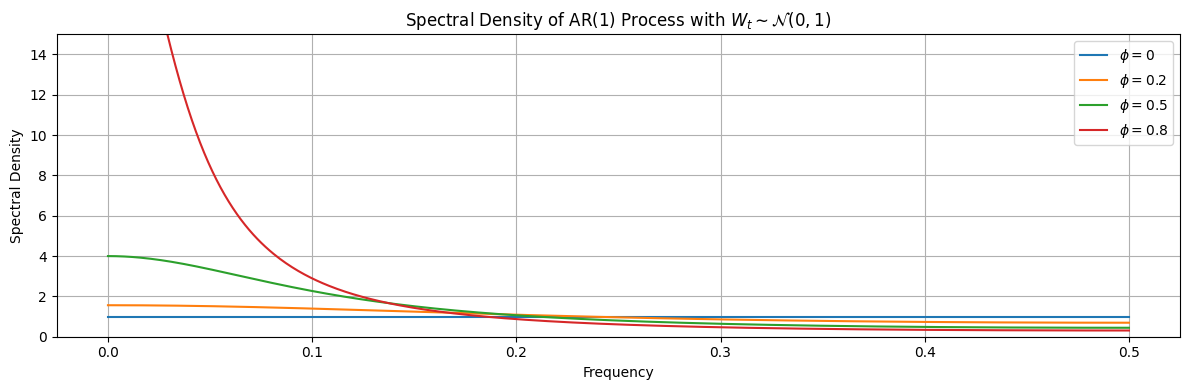

In [8]:
sigma = 1
phi_values = [0, 0.2, 0.5, 0.8]
frequencies = np.linspace(0, 0.5, 500)

fig, [ax] = get_figure()
for phi in phi_values:
    spectral_density = sigma**2 / (1 - 2 * phi * np.cos(2 * np.pi * frequencies) + phi**2)
    time_plot(
        frequencies,
        spectral_density,
        title="Spectral Density of AR(1) Process with $W_t\sim \mathcal{N}(0, 1)$",
        xlabel="Frequency",
        ylabel="Spectral Density",
        label=f"$\\phi = {phi}$",
        ax=ax,
        ylim=(0, 15),
    )
ax.legend()
fig.tight_layout()

### ARMA(p,q) process

<>:21: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:21: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_37007/160065176.py:21: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  title="Spectral Density of ARMA(p,q) Process with $W_t\sim \mathcal{N}(0, 1)$",


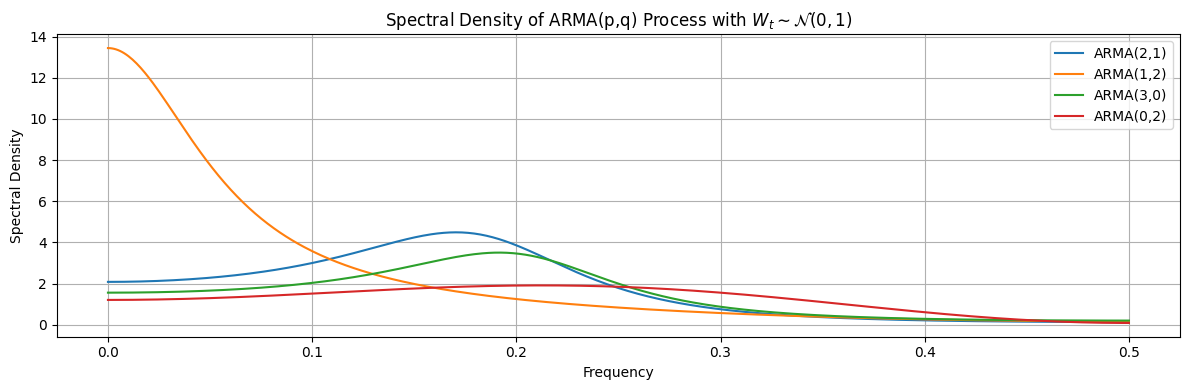

In [9]:
sigma = 1
frequencies = np.linspace(0, 0.5, 500)
arma_configs = [
    {"phi": [0.5, -0.4], "theta": [0.3], "label": "ARMA(2,1)"},
    {"phi": [0.7], "theta": [0.2, -0.1], "label": "ARMA(1,2)"},
    {"phi": [0.6, -0.5, 0.1], "theta": [], "label": "ARMA(3,0)"},
    {"phi": [], "theta": [0.4, -0.3], "label": "ARMA(0,2)"},
]

fig, [ax] = get_figure()
for config in arma_configs:
    phi = config["phi"]
    theta = config["theta"]
    label = config["label"]
    
    spectral_density = arma_theoretical_spectral_density(frequencies, sigma, phi, theta)

    time_plot(
        frequencies,
        spectral_density,
        title="Spectral Density of ARMA(p,q) Process with $W_t\sim \mathcal{N}(0, 1)$",
        xlabel="Frequency",
        ylabel="Spectral Density",
        label=label,
        ax=ax,
    )
fig.tight_layout()

## Periodogram and spectral density

<>:29: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:29: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_37007/199112857.py:29: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  title=f"Spectral Density of {label} Process with $W_t\sim \mathcal{{N}}(0, 1)$",


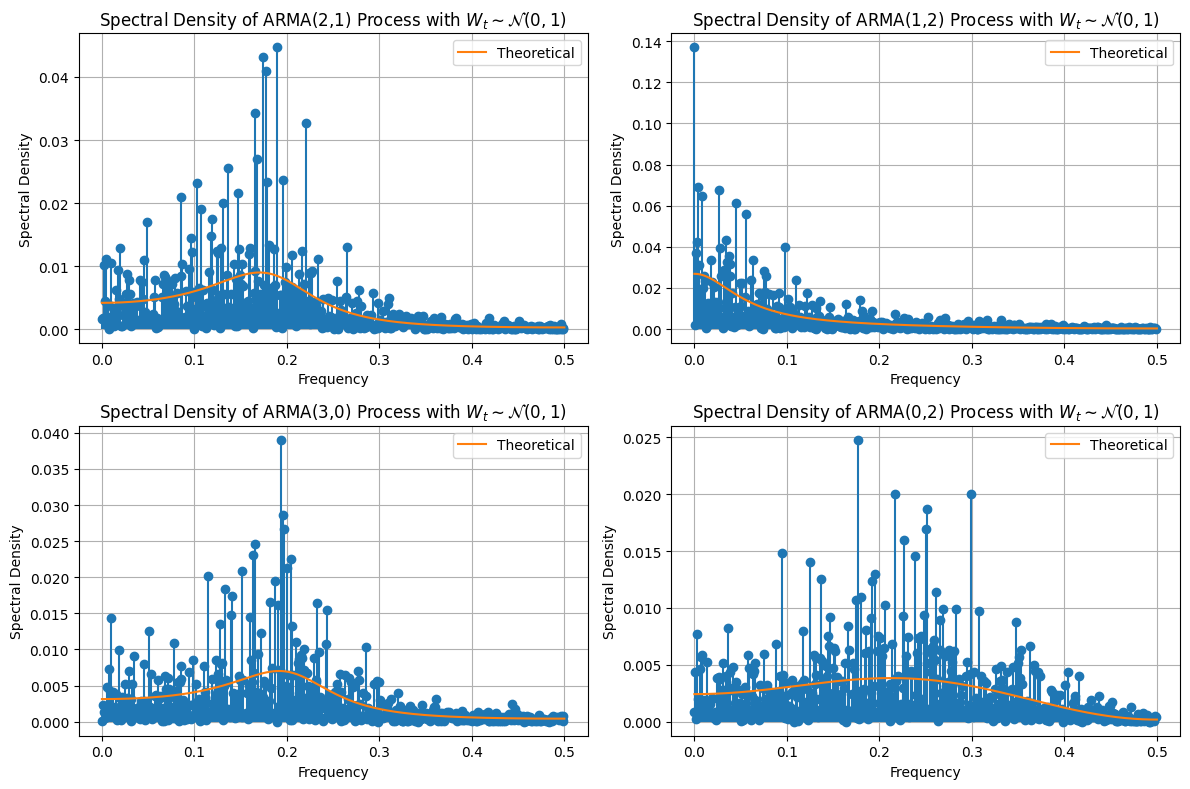

In [10]:
np.random.seed(42)
n = 1000
sigma = 1
frequencies = np.linspace(0, 0.5, n)
nrows= np.ceil(len(arma_configs)/2)
fig, axs = get_figure(nrows=len(arma_configs)//2, ncols=2, figsize=(12, 8))
for ax, config in zip(axs, arma_configs):
    phi = config["phi"]
    theta = config["theta"]
    label = config["label"]
    
    model = ArmaProcess(
        ar=np.r_[1, -np.array(phi)],
        ma=np.r_[1, np.array(theta)],
    )
    arma_series = model.generate_sample(nsample=n)
    spectral_density = arma_theoretical_spectral_density(frequencies, sigma, phi, theta)
    # Multiply by two for the negative frequencies, divide by n to relate to the periodogram since P(w) = f(w)/n
    spectral_density = 2*spectral_density/n         
    plot_fft(
        ax,
        arma_series,
        periodogram=True,
    )
    
    time_plot(
        frequencies,
        spectral_density,
        title=f"Spectral Density of {label} Process with $W_t\sim \mathcal{{N}}(0, 1)$",
        xlabel="Frequency",
        ylabel="Spectral Density",
        label="Theoretical",
        ax=ax,
    )
fig.tight_layout()

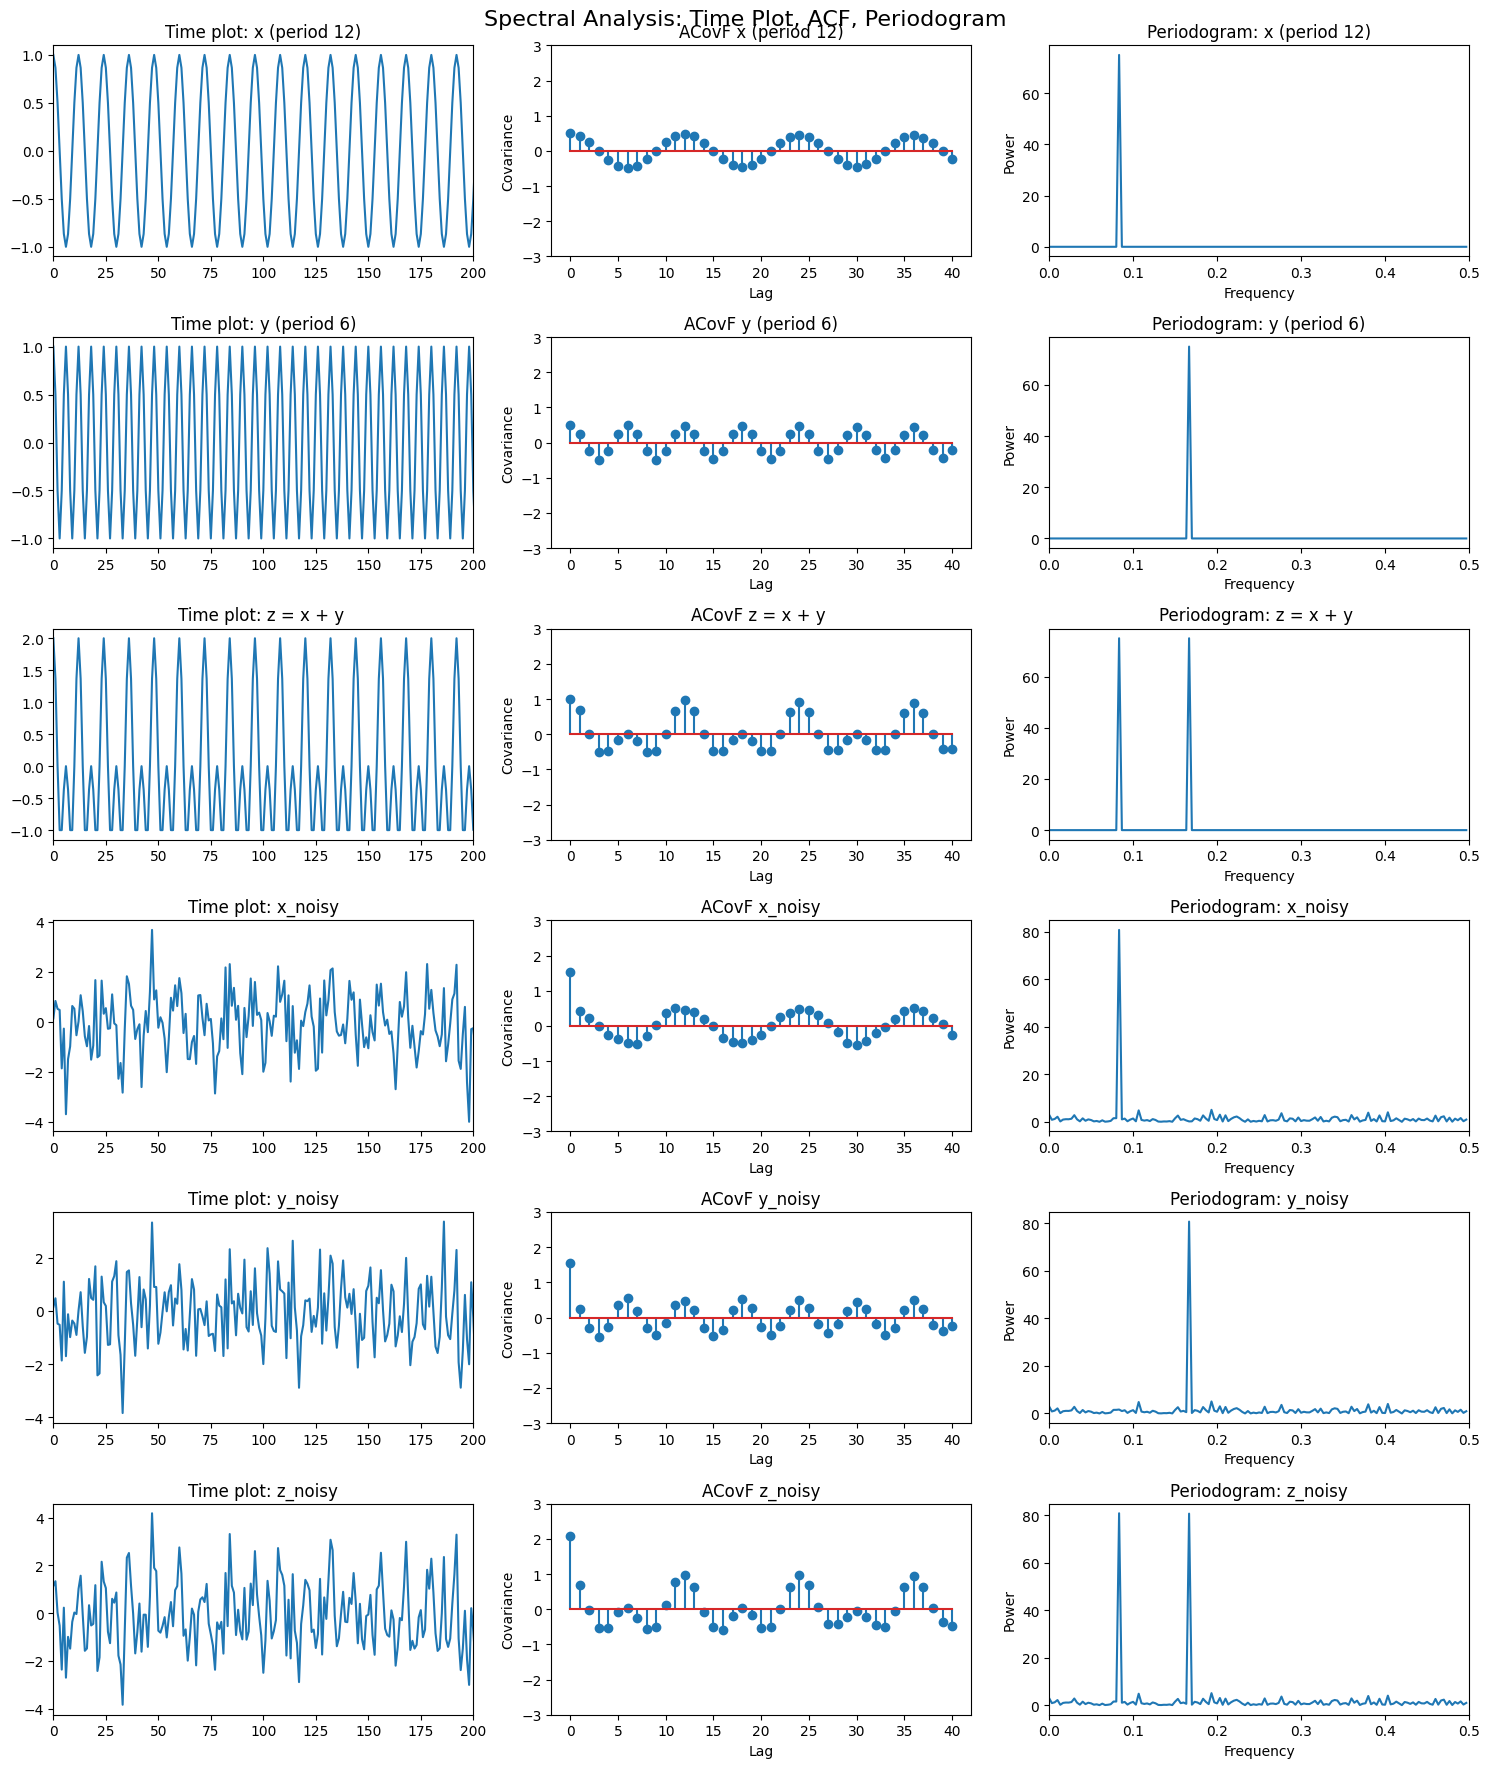

In [ ]:

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acovf

def acovf_plot(x, nlags, ax, title=""):
    ac = acovf(x, nlag=nlags, fft=True)
    ax.stem(range(len(ac)), ac)
    ax.set_title(f"ACovF {title}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Covariance")

def periodogram(x):
    n = len(x)
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(n, d=1)   
    P = (1/n) * np.abs(X)**2
    mask = freqs >= 0                
    return freqs[mask], P[mask]

n = 300
t = np.arange(n)


# Periodic signals
x = np.cos(2 * np.pi * t / 12)        # period = 12
y = np.cos(2 * np.pi * t / 6)         # period = 6
z = x + y                             

noise = np.random.normal(scale=1, size=n)
x_noisy = x + noise
y_noisy = y + noise
z_noisy = z + noise

signals = [
    (x, "x (period 12)"),
    (y, "y (period 6)"),
    (z, "z = x + y "),
    (x_noisy, "x_noisy"),
    (y_noisy, "y_noisy"),
    (z_noisy, "z_noisy"),
]


fig, axs = plt.subplots(len(signals), 3, figsize=(15, 18))
fig.suptitle("Spectral Analysis: Time Plot, ACF, Periodogram", fontsize=16)

for i, (signal, name) in enumerate(signals):

    #time plot 
    axs[i, 0].plot(t, signal)
    axs[i, 0].set_title(f"Time plot: {name}")
    axs[i, 0].set_xlim(0, 200)

    #autocovariance
    acovf_plot(signal, nlags=40, ax=axs[i, 1], title=name)
    axs[i, 1].set_ylim(-3, 3)

    #periodogram
    f, P = periodogram(signal)
    axs[i, 2].plot(f, P)
    axs[i, 2].set_title(f"Periodogram: {name}")
    axs[i, 2].set_xlim(0, 0.5)
    axs[i, 2].set_xlabel("Frequency")
    axs[i, 2].set_ylabel("Power")

plt.tight_layout()
plt.show()

### Compute periodogram for real-world SST dataset: Sea surface temperature

/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_37007/1387103665.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim(0, P.max() * 1.1)


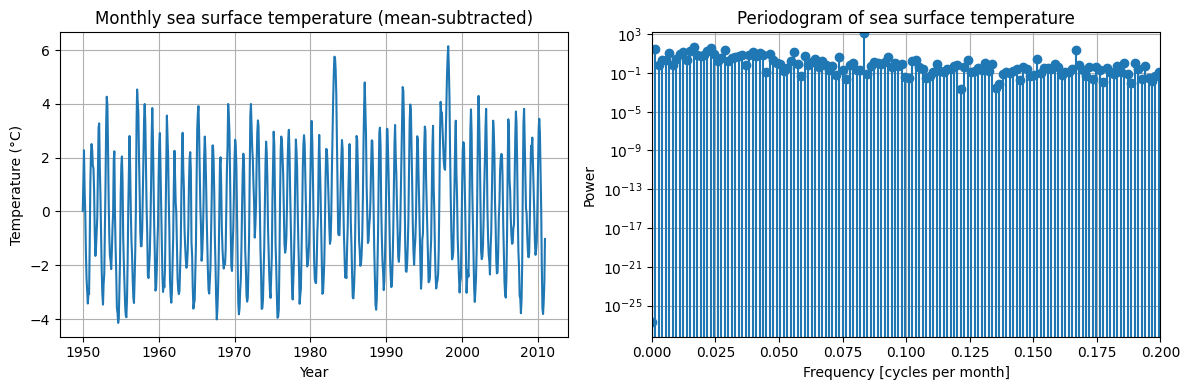

In [12]:
df = get_sea_surface_temp()
df = df.set_index("DATE").sort_index()

series = df["value"].asfreq("MS")

x = series - series.mean()

n = len(x)
X = np.fft.fft(x.values)
freqs = np.fft.fftfreq(n, d=1) 

# positive frequencies only
mask = freqs >= 0
freqs_pos = freqs[mask]
P = (1/n) * (np.abs(X[mask])**2)  

fig, axs = get_figure(ncols=2, figsize=(12,4))

# time plot
time_plot(
    x=x.index, 
    y=x,
    ax=axs[0],
    title="Monthly sea surface temperature (mean-subtracted)",
    xlabel="Year",
    ylabel="Temperature (°C)"
)

# periodogram 
axs[1].stem(freqs_pos, P, basefmt=" ") 
axs[1].set_title("Periodogram of sea surface temperature")
axs[1].set_xlabel("Frequency [cycles per month]")
axs[1].set_ylabel("Power")

axs[1].set_xlim(0, 0.2)
axs[1].set_yscale("log")
axs[1].set_ylim(0, P.max() * 1.1)

fig.tight_layout()


### Compare clean vs noisy periodogramm

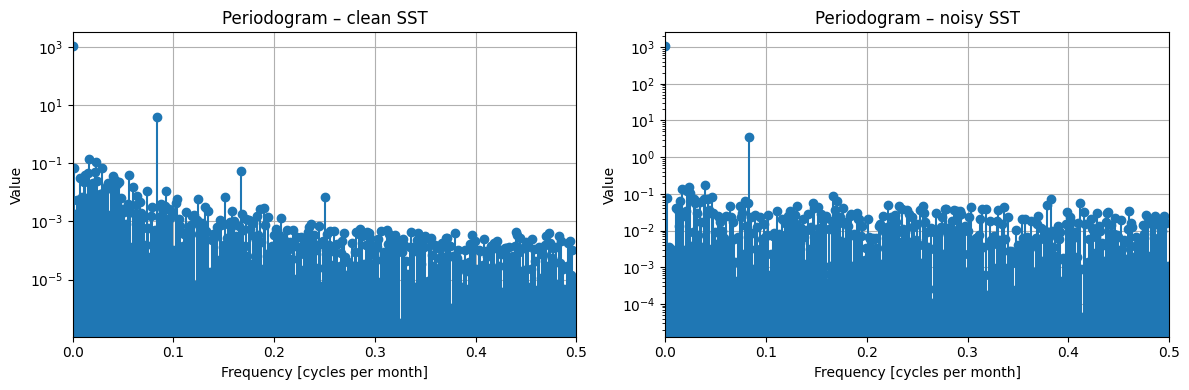

In [13]:

rng = np.random.default_rng(42)
noise = rng.normal(loc=0.0, scale=series.std(), size=len(series))
series_noisy = series + noise

fig, axs = get_figure(ncols=2, figsize=(12, 4))

#clean
plot_fft(
    axs[0],
    series,
    periodogram=True,
    sample_spacing_name="month"
)
axs[0].set_title("Periodogram – clean SST")
axs[0].set_xlim(0, 0.5)
axs[0].set_yscale("log")

#noisy
plot_fft(
    axs[1],
    series_noisy,
    periodogram=True,
    sample_spacing_name="month"
)
axs[1].set_title("Periodogram – noisy SST")
axs[1].set_xlim(0, 0.5)
axs[1].set_yscale("log")

fig.tight_layout()
